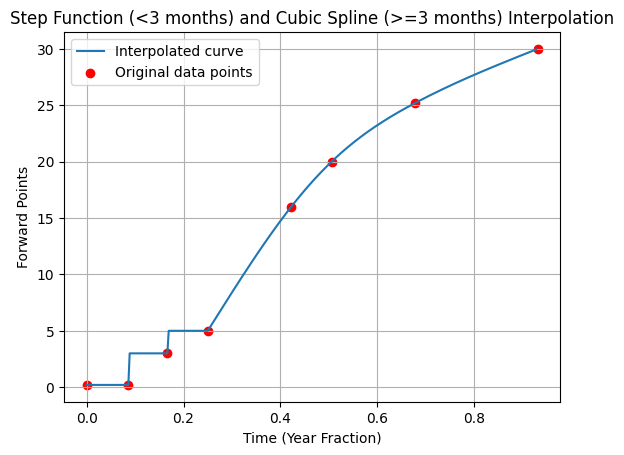

In [3]:
import QuantLib as ql
import matplotlib.pyplot as plt
import numpy as np

# Example maturities and forward points (months and forward points)
maturities = [ql.Date(1, 1, 2024),  ql.Date(1, 2, 2024), ql.Date(1, 3, 2024),
              ql.Date(31, 3, 2024),  ql.Date(1, 6, 2024), ql.Date(1, 7, 2024), ql.Date(1, 9, 2024), ql.Date(1, 12, 2024)]
forward_points = [0.2, 0.2, 3, 5, 16, 20, 25.2, 30.0]

# Convert maturities to time fractions (year fractions from a reference date)
reference_date = ql.Date(1, 1, 2024)
times = [ql.Actual360().yearFraction(reference_date, m) for m in maturities]

# Split the data for the two regions: Step function for t < 3 months, cubic for t >= 3 months
# BackwardFlat interpolation for t < 3 months
step_times = [t for t in times if t <= ql.Actual360().yearFraction(reference_date, ql.Date(31, 3, 2024))]
step_points = forward_points[:len(step_times)]
backward_flat_interp = ql.BackwardFlatInterpolation(step_times, step_points)

# CubicSpline interpolation for t >= 3 months
cubic_times = [t for t in times if t >= ql.Actual360().yearFraction(reference_date, ql.Date(31, 3, 2024))]
cubic_points = forward_points[len(step_times) - 1:]  # Include the point at 3 months for continuity

# The 'DerivativeApprox' attribute is accessed through the 'BoundaryCondition' class
cubic_interp = ql.CubicNaturalSpline(cubic_times, cubic_points)

# Interpolating function
def interpolate(t):
    if t < ql.Actual360().yearFraction(reference_date, ql.Date(31, 3, 2024)):
        return backward_flat_interp(t)
    else:
        return cubic_interp(t)

# Plotting the results to visualize the interpolation
# Generate a range of maturities (1 to 12 months)
maturity_dates = [reference_date + ql.Period(i, ql.Days) for i in range(335)]
maturity_times = [ql.Actual360().yearFraction(reference_date, d) for d in maturity_dates]
interpolated_values = [interpolate(t) for t in maturity_times]

# Plot the original data points and the interpolation
plt.plot(maturity_times, interpolated_values, label="Interpolated curve")
plt.scatter(times, forward_points, color='red', label="Original data points")
plt.title("Step Function (<3 months) and Cubic Spline (>=3 months) Interpolation")
plt.xlabel("Time (Year Fraction)")
plt.ylabel("Forward Points")
plt.legend()
plt.grid(True)
plt.show()